<h1> Research Project: Timing Variables </h1>

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset
import pickle

<h2> 1. Data </h2>

- [S&P500 Historical Constituents](#sp500_components)
- [Price and Fundamental Data](#data)

<b> Data Sources: </b>
- Historical S&P500 Constituents - https://github.com/fja05680/sp500
- Price Data - CRSP/Compustat Merged Database
- Fundamental Data - CRSP/Compustat Merged Database
- Timing Variables - FRED CPI , Chicago Fed National Activity Index

In [2]:
# Set Base Directory
base_dir = r"C:\Users\tyyew\Desktop\Quant\Columbia MAFN\Study Materials\Sem 3\Quantitative Methods in Investment Management\Project"

<a id = 'sp500_components'> </a>
<h3> S&P500 Historical Constituents </h3>

In [3]:
# create list of historical S&P500 constituents - for data query
filename_1 = r"S&P Historical Constituents.csv"
index = pd.read_csv(base_dir + "\\" + filename_1, sep = ',', parse_dates = ['date'], index_col = 'date')

index_set = set()
for row in index['tickers']:
    list_ = row.split(',')
    index_set.update(list_)
    
string = " ".join(index_set)
text_file = open(r"S&P500.txt", "w")
text_file.write(string)
text_file.close()

In [4]:
# create one-hot table
sp500_dict = {}
date_idx = pd.to_datetime(index.index)
for idx in date_idx: 
    list_ = index.loc[idx,'tickers'].split(',')
    sp500_dict[idx] = list_
    
sp500_member = pd.DataFrame(0, index = date_idx, columns = index_set)
for date in date_idx: 
    sp500_member.loc[date, sp500_dict[date]] = 1

In [5]:
sp500_member.index + pd.offsets.MonthEnd(0)

DatetimeIndex(['1996-01-31', '1996-01-31', '1996-01-31', '1996-01-31',
               '1996-01-31', '1996-01-31', '1996-01-31', '1996-01-31',
               '1996-01-31', '1996-01-31',
               ...
               '2020-12-31', '2021-01-31', '2021-01-31', '2021-02-28',
               '2021-03-31', '2021-04-30', '2021-05-31', '2021-06-30',
               '2021-07-31', '2021-08-31'],
              dtype='datetime64[ns]', name='date', length=2638, freq=None)

In [6]:
# get monthly historical constituent
date_range = pd.date_range('1995-01-31', '2021-12-31', freq = 'M')
date_range0 = pd.date_range('1996-01-31', '2021-11-30', freq = 'M')
date_range1 = pd.date_range('1996-02-29', '2021-12-31', freq = 'M')
sp500_member_M = pd.DataFrame(0, index = date_range, columns = index_set)
sp500_member_M

,USBC,JOS,CVG,FANG,APA,TMUS,CBS,SYY,GP,PHM,...,FSLR,ODFL,PAYC,KMX,MO,DVN,CDW,TEG,CAR,BTUUQ
1995-01-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1995-02-28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1995-03-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1995-04-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1995-05-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-09-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-10-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-11-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a id = 'data'> <a>
<h3> Price and Fundamental Data </h3>

In [7]:
filename_2 = r"Factor Data.xlsx"

prices_df = pd.read_excel(base_dir + "\\" + filename_2, sheet_name = 'Price Data', index_col = 0, usecols = ['Date', 'PERMNO', 'Ticker', 'Price', 'Returns'])
value_df = pd.read_excel(base_dir + "\\" + filename_2, sheet_name = 'Value Signals', index_col = 0, usecols = ['Date', 'PERMNO', 'Ticker', 'B/M', 'CAPE', 'EVM', 'P/O', 'P/E', 'P/S', 'P/CF', 'DPR', 'P/B'])

# change dates to month end
prices_df.index = prices_df.index + pd.offsets.MonthEnd(0)
value_df.index = value_df.index + pd.offsets.MonthEnd(0)

# to get overall universe and subset of universe 
stock_set = set(prices_df['Ticker'])
stock_set.remove(np.nan)
master_set = stock_set & index_set

print(f'Data Universe: {len(stock_set)}, Combined Universe: {len(master_set)}')

Data Universe: 1392, Combined Universe: 946


In [8]:
# Returns Data
stock_returns = pd.DataFrame(index = date_range, columns = stock_set)
returns_df = prices_df[['Ticker', 'Returns']].dropna()
for date in date_range: 
    stock_returns.loc[date, list(returns_df.loc[date, 'Ticker'])] = returns_df.loc[date, 'Returns'].values

# Price Data
stock_prices = pd.DataFrame(index = date_range, columns = stock_set)
dollar_df = prices_df[['Ticker', 'Price']].dropna()
for date in date_range: 
    stock_prices.loc[date, list(dollar_df.loc[date, 'Ticker'])] = dollar_df.loc[date, 'Price'].values
    
# Benchmark
filename_3 = r"Timing Variables.xlsx"
benchmark_df = pd.read_excel(base_dir + "\\" + filename_3,sheet_name = "Benchmark", index_col = 0).fillna(0)
benchmark_ret = benchmark_df['S&P500 Returns']
rf_ret = benchmark_df['RF']

In [ ]:
rf_ret.loc[date_range1[0]- pd.offsets.MonthEnd(12):date_range1[0]]

In [51]:
benchmark_ret

Date
1963-01-31    0.000000
1963-02-28    0.013219
1963-03-31   -0.003792
1963-04-30    0.047053
1963-05-31    0.020070
                ...   
2022-06-30   -0.035000
2022-07-31    0.003279
2022-08-31    0.063101
2022-09-30   -0.074074
2022-10-31   -0.032325
Name: S&P500 Returns, Length: 718, dtype: float64

In [85]:
(mom_ret['12M'].corr(benchmark_ret.loc[date_range1]))**2

0.03898098546459957

In [82]:
x = mom_ret['12M']
x = sm.add_constant(x)
y = benchmark_ret.loc[date_range1]
model = sm.OLS(y, x).fit()
model.rsquared

0.03898098546459938

In [38]:
# compute beta
for date in date_range1: 
    y = rf_ret.loc[date_range1]

1996-02-29    0.0483
1996-03-31    0.0496
1996-04-30    0.0495
1996-05-31    0.0502
1996-06-30    0.0509
               ...  
2021-08-31    0.0004
2021-09-30    0.0005
2021-10-31    0.0005
2021-11-30    0.0007
2021-12-31    0.0004
Freq: M, Name: RF, Length: 311, dtype: float64

<h2> 2. Methodology </h2>

<h2> 3. Implementation </h2>

- [Momentum Factor Construction](#mom_factor)
- [Value Factor Construction](#val_factor)
- [Timing Variables and Factor Returns](#factor_timing)
- [Results](#results)

In [9]:
# statistics toolkit
def winsorize(x, ub = 99, lb = 1): 
    upper = np.percentile(x[~pd.isna(x)], ub)
    lower = np.percentile(x[~pd.isna(x)], lb)
    return np.where(x>upper, upper, np.where(x < lower, lower, x))

def z_score(df):
    return df.sub(df.mean(axis = 1), axis = 0).div(df.std(axis = 1), axis = 0)

def run_ols_sm(predictor, factor, start_date_, end_date_): # regression with t-stats
    start_date1 = start_date_ + pd.offsets.MonthEnd(1)
    end_date1 = end_date_ + pd.offsets.MonthEnd(1)
    x = timing_var_df.loc[start_date_:end_date_, predictor] 
    # x_norm = (x - x.mean())/x.std()
    X_train = sm.add_constant(x)
    y_train = np.array(factor_ret_df.loc[start_date1:end_date1, factor])
    model = sm.OLS(y_train, X_train)
    results = model.fit()

    betas = results.params
    tstats = results.tvalues
    r2 = results.rsquared
    
    return betas, tstats, r2


In [ ]:
# factor construction toolkit
def calc_returns(weights, returns): 
    return (weights.shift(1, freq = 'infer') * returns).sum(axis = 1) 

def calc_vol(returns_df, weights_df, window = 12): 
    N = returns_df.shape[0]
    start = window

    vol_df = pd.DataFrame(0, index = date_range, columns = ['Vol'])

    for t in range(start, N, 1): 
        V = returns_df.iloc[t-window:t].fillna(0).cov(ddof = 0) # sample covariance matrix
        weight_t = weights_df.iloc[t].fillna(0)
        vol_df.iloc[t,:] = np.sqrt(weight_t @ V @ weight_t * 12) # portfolio volatility

    return vol_df

def calc_beta(market_df, returns_df): 
    return market_df

def calc_turnover(weights_df): 
    turnover_df = weights_df.shift(1, freq = 'infer') - weights_df
    return np.sum(np.abs(turnover_df), axis = 1)

def calc_drawdown(returns_df, start_date):
    drawdown_df = pd.DataFrame(0, index = returns_df.index, columns = returns_df.columns)
    for last_date in drawdown_df.index: 
        drawdown_df.loc[last_date] = returns_df.loc[last_date] - np.max(returns_df.loc[start_date:last_date], axis = 0)
    return drawdown_df

def calc_leverage(weights_df): 
    return weights_df.abs().sum(axis = 1)

In [10]:
# factor construction wrappers
def signal_calc(signal, target_vol = 0.1): # compute self-financing beta neutral signal returns
    
    # step 1 - take z-score
    signal_z = z_score(signal).fillna(0)

    # step 2 - vol scale
    signal_vol = calc_vol(stock_returns, signal_z)
    vol_ratio = target_vol/signal_vol.loc[date_range0].values
    signal_weights = signal_z.loc[date_range0].mul(vol_ratio, axis = 0)

    # step 3 - beta neutralize
    
    # step 4 - compute returns
    signal_ret = (signal_weights.shift(1, freq = 'infer') * stock_returns.loc[date_range1]).sum(axis = 1)
    
    return signal_weights, signal_ret

def composite_calc(signal_dict, signal_group, target_vol = 0.1): # compute self-financing beta neutral composite returns
    
    signal_weights = {}
    for signal in signal_group: 
        # step 1 - take z-score
        signal_df = signal_dict[signal]
        signal_z = z_score(signal_df).fillna(0)

        # step 2 - vol scale
        signal_vol = calc_vol(stock_returns, signal_z)
        vol_ratio = target_vol/signal_vol.loc[date_range0].values
        signal_weights[signal] = signal_z.loc[date_range0].mul(vol_ratio, axis = 0)
        
    # step 3- equal-weighted composite
    composite_weights = pd.DataFrame(0, index = date_range0, columns = signal_z.columns)
    for signal in signal_group: 
        composite_weights += signal_weights[signal].fillna(0)
    composite_weights = composite_weights/len(signal_group) # taking average
    
    # step 4 - beta neutralize

    # step 5 - compute hedged returns
    composite_ret = (composite_weights.shift(1, freq = 'infer') * stock_returns.loc[date_range1]).sum(axis = 1)
    
    return composite_weights, composite_ret

<a id = 'mom_factor'> </a>
<h3> Momentum Factor Construction </h3> 

<h4> <font color = 'darkblue'> Testing momentum signals </font> </h4> 

In [11]:
# populating signal
mom_signals = {}
mom6_df = pd.DataFrame(index = date_range , columns = stock_set)
mom8_df = pd.DataFrame(index = date_range , columns = stock_set)
mom10_df = pd.DataFrame(index = date_range , columns = stock_set)
mom12_df = pd.DataFrame(index = date_range , columns = stock_set)

for date in date_range0: 
    mom6_df.loc[date] = (stock_prices.loc[date - pd.offsets.MonthEnd(1)] / stock_prices.loc[date - pd.offsets.MonthEnd(6)]) - 1
    mom6_df.loc[date] = winsorize(mom6_df.loc[date].values)
    mom8_df.loc[date] = (stock_prices.loc[date - pd.offsets.MonthEnd(1)] / stock_prices.loc[date - pd.offsets.MonthEnd(8)]) - 1
    mom8_df.loc[date] = winsorize(mom8_df.loc[date].values)
    mom10_df.loc[date] = (stock_prices.loc[date - pd.offsets.MonthEnd(1)] / stock_prices.loc[date - pd.offsets.MonthEnd(10)]) - 1
    mom10_df.loc[date] = winsorize(mom10_df.loc[date].values)
    mom12_df.loc[date] = (stock_prices.loc[date - pd.offsets.MonthEnd(1)] / stock_prices.loc[date - pd.offsets.MonthEnd(12)]) - 1
    mom12_df.loc[date] = winsorize(mom12_df.loc[date].values)

mom_signals['6M'] = mom6_df
mom_signals['8M'] = mom8_df
mom_signals['10M'] = mom10_df
mom_signals['12M'] = mom12_df

<ipython-input-9-92a67481e3d6>:5: RuntimeWarning: invalid value encountered in greater
  return np.where(x>upper, upper, np.where(x < lower, lower, x))
<ipython-input-9-92a67481e3d6>:5: RuntimeWarning: invalid value encountered in less
  return np.where(x>upper, upper, np.where(x < lower, lower, x))


In [373]:
# compute returns
mom_signals_list = ['6M', '8M', '10M', '12M']
mom_weights, mom_ret = {}, {}
for signal in mom_signals_list:
    mom_weights[signal], mom_ret[signal] = signal_calc(mom_signals[signal], 0.1) # 10% target vol

mom_ret_df = pd.DataFrame(mom_ret)

In [374]:
# Summary 
svar_summary = pd.DataFrame(columns = ['Return', 'Volatility', 'Sharpe Ratio'])
svar_summary['Return'] = mom_ret_df.mean() * 12
svar_summary['Volatility'] = mom_ret_df.std() * 12
svar_summary['Sharpe Ratio'] = mom_ret_df.mean() / mom_ret_df.std()
svar_summary.T

,6M,8M,10M,12M
Return,0.024882,0.034153,0.055166,0.059310
Volatility,0.278969,0.303538,0.385187,0.428252
Sharpe Ratio,0.089191,0.112516,0.143220,0.138493


In [375]:
svar_summary.T.to_clipboard()

<AxesSubplot:>

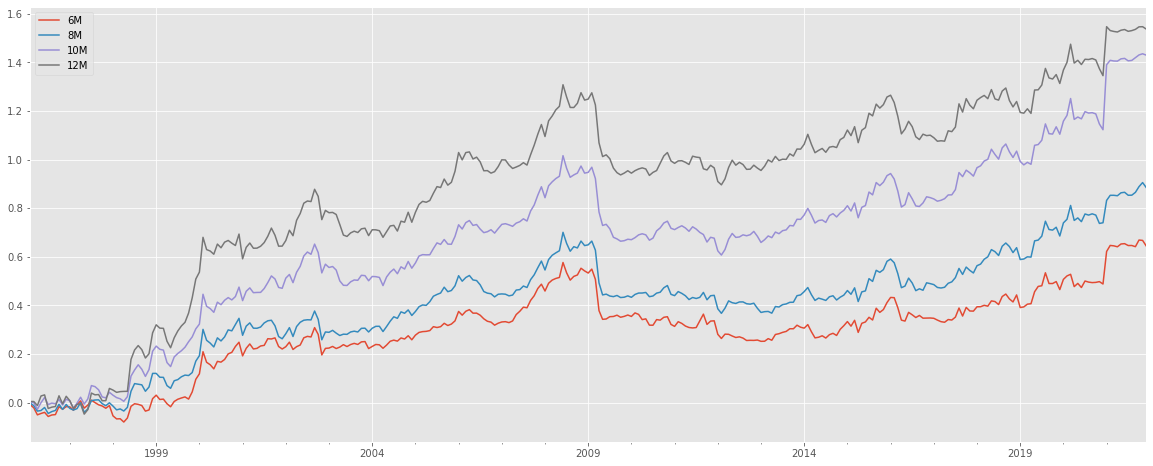

In [130]:
mom_ret_df.cumsum().plot(figsize = (20,8))

<AxesSubplot:>

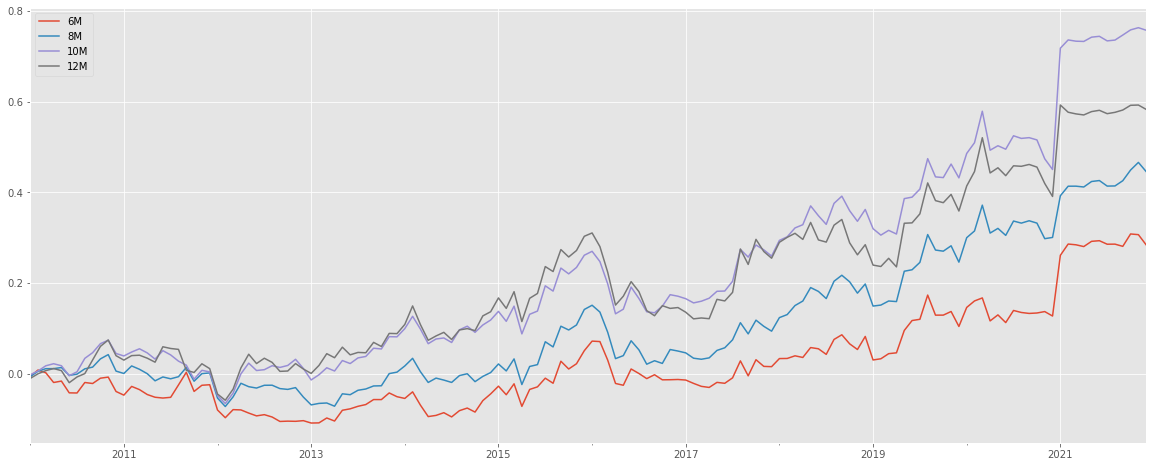

In [132]:
mom_ret_df.loc[date_range_recent].cumsum().plot(figsize = (20,8))

12M momentum seems to work well enough, so we are going to use it as our momentum factor for the timing exercise.

<a id = 'val_factor'> </a> 
<h3> Value Factor Construction </h3> 

<h4> <font color = 'darkblue'> Testing value signals </font> </h4> 

In [14]:
# populating signals
value_signals = {}
value_signals_list = ['P/B', 'CAPE', 'EVM', 'P/O', 'P/E', 'P/S', 'P/CF', 'DPR']
for signal in value_signals_list:
    signal_df = pd.DataFrame(index = date_range0, columns = stock_set)
    var_df = value_df[['Ticker', signal]]
    for date in date_range: 
        signal_df.loc[date, list(var_df.loc[date,'Ticker'])] = winsorize(var_df.loc[date,signal].values)
    signal_df = signal_df[stock_set]
    
    value_signals[signal] = signal_df

In [15]:
# inverting price ratios
price_ratios = ['CAPE', 'EVM', 'P/O', 'P/E', 'P/S', 'P/CF', 'P/B']
for ratio in price_ratios:
    value_signals[ratio] = 1 / value_signals[ratio]

In [16]:
# compute returns
value_weights, value_ret = {}, {}
for signal in value_signals_list:
    value_weights[signal], value_ret[signal] = signal_calc(value_signals[signal], 0.1) # 10% target vol

value_ret_df = pd.DataFrame(value_ret, columns= value_signals)

<ipython-input-10-a2b460324e96>:8: RuntimeWarning: divide by zero encountered in true_divide
  vol_ratio = target_vol/signal_vol.loc[date_range0].values


In [17]:
# Summary
svar_summary = pd.DataFrame(columns = ['Return', 'Volatility', 'Sharpe Ratio'])
svar_summary['Return'] = value_ret_df.mean() * 12
svar_summary['Volatility'] = value_ret_df.std() * 12
svar_summary['Sharpe Ratio'] = value_ret_df.mean() / value_ret_df.std()
svar_summary.T

,P/B,CAPE,EVM,P/O,P/E,P/S,P/CF,DPR
Return,0.035568,-0.079209,-0.006177,0.016302,0.000307,0.093352,0.157471,-0.076829
Volatility,0.701005,0.803378,0.600563,0.923386,0.847027,0.761214,0.774660,0.435219
Sharpe Ratio,0.050738,-0.098595,-0.010285,0.017655,0.000363,0.122636,0.203278,-0.176529


In [371]:
svar_summary.T.to_clipboard()

Okay CAPE and EVM not working for some reason... DPR can be entirely due to data availability, but the other two are kinda surprising. P/CF and P/S seems to be working very well.. P/O and P/E looks kinda bad too... Can we do something about it?

In [18]:
# correlation
corr_ = value_ret_df.corr()
corr_.style.background_gradient(cmap='coolwarm').set_precision(2)

,P/B,CAPE,EVM,P/O,P/E,P/S,P/CF,DPR
P/B,1.00,-0.28,0.03,-0.34,-0.41,0.59,0.50,0.38
CAPE,-0.28,1.00,0.32,0.80,0.80,-0.42,-0.23,0.02
EVM,0.03,0.32,1.00,0.34,0.38,-0.03,0.11,0.21
P/O,-0.34,0.80,0.34,1.00,0.91,-0.37,-0.25,0.02
P/E,-0.41,0.80,0.38,0.91,1.00,-0.49,-0.26,-0.04
P/S,0.59,-0.42,-0.03,-0.37,-0.49,1.00,0.51,0.22
P/CF,0.50,-0.23,0.11,-0.25,-0.26,0.51,1.00,0.16
DPR,0.38,0.02,0.21,0.02,-0.04,0.22,0.16,1.00


The returns are surprisingly uncorrelated... P/S is strongly correlated with P/B, and P/E is strongly correlated with P/E. 

<AxesSubplot:>

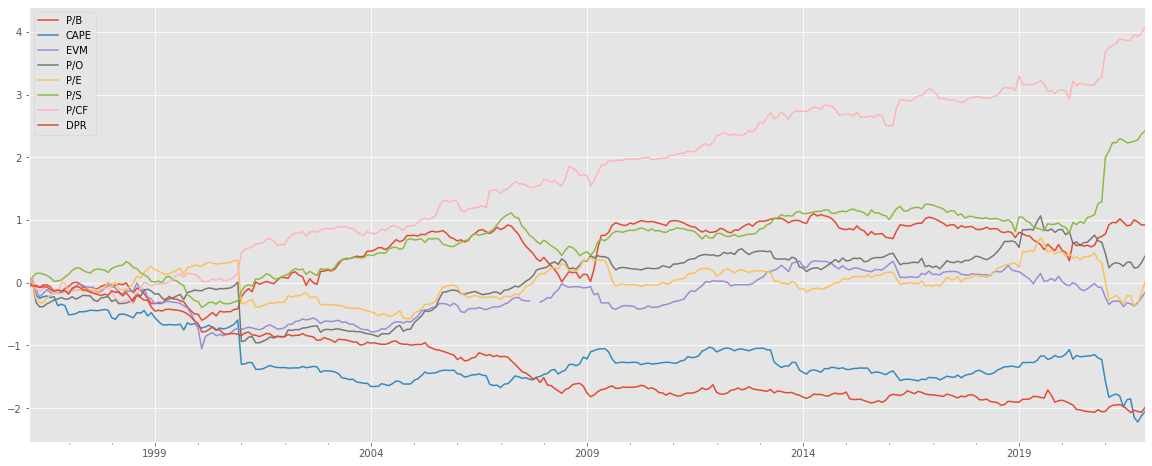

In [370]:
value_ret_df.cumsum().plot(figsize = (20,8))

<h4> <font color = 'darkblue'> Testing value composite </font> </h4> 

In [19]:
comp1_list = ['P/CF', 'P/B', 'P/O', 'P/E', 'P/S']
comp1_w, comp1_r = composite_calc(value_signals, comp1_list, target_vol = 0.1)

comp2_list = ['P/CF', 'P/B', 'P/S', 'P/O']
comp2_w, comp2_r = composite_calc(value_signals, comp2_list, target_vol = 0.1)

comp3_list = ['P/CF', 'P/E', 'P/S']
comp3_w, comp3_r = composite_calc(value_signals, comp3_list, target_vol = 0.1)

In [20]:
# summary stats
comp1_df = pd.DataFrame(comp1_r, columns = ['Composite 1']) 
comp2_df = pd.DataFrame(comp2_r, columns = ['Composite 2']) 
comp3_df = pd.DataFrame(comp3_r, columns = ['Composite 3']) 
value_comp_df = value_ret_df[comp1_list].join([comp1_df, comp2_df, comp3_df])

cvar_summary = pd.DataFrame(columns = ['Return', 'Volatility', 'Sharpe Ratio'])
cvar_summary['Return'] = value_comp_df.mean() * 12
cvar_summary['Volatility'] = value_comp_df.std() * 12
cvar_summary['Sharpe Ratio'] = value_comp_df.mean() / value_comp_df.std()
cvar_summary.T

,P/CF,P/B,P/O,P/E,P/S,Composite 1,Composite 2,Composite 3
Return,0.157471,0.035568,0.016302,0.000307,0.093352,0.060600,0.075673,0.095464
Volatility,0.774660,0.701005,0.923386,0.847027,0.761214,0.383036,0.431537,0.618384
Sharpe Ratio,0.203278,0.050738,0.017655,0.000363,0.122636,0.158210,0.175358,0.154376


In [372]:
cvar_summary.T.to_clipboard()

Ok the SRs are slightly worse than P/CF (maybe because of leverage?). Anyways, it still looks quite decent, so we will use composite 1 as our value factor for the timing exercise. 

<a id = 'bench_port'> </a>
<h3> Benchmark Portfolio - Static Factor Loading</h3>

In [367]:
# portfolio performance measures
def summary_table(weight_dict, ret_series, start_date, end_date): 
    ret_annualized = np.mean(ret_series.loc[start_date:end_date]) * 12
    vol_annualized = np.std(ret_series.loc[start_date:end_date]) * 12
    sharpe = np.mean(ret_series.loc[start_date:end_date])/ np.std(ret_series.loc[start_date:end_date])
    avg_drawdown = np.mean(calc_drawdown(ret_series, start_date))
    max_drawdown = np.amin(calc_drawdown(ret_series, start_date))
    # transaction_cost =  
    summary = pd.DataFrame(columns = ['Return', 'Volatility', 'Sharpe Ratio', 'Mean Drawdown', 'Max Drawdown', 'Turnover', 'Leverage'])
    summary['Return'] = ret_annualized
    summary['Volatility'] = vol_annualized
    summary['Sharpe Ratio'] = sharpe
    summary['Mean Drawdown'] = avg_drawdown
    summary['Max Drawdown'] = max_drawdown
    for idx in summary.index: 
        summary.loc[idx, 'Turnover'] = np.mean(calc_turnover(weight_dict[idx])) * 12
        summary.loc[idx, 'Leverage'] = np.mean(calc_leverage(weight_dict[idx]))
    return summary.T

In [341]:
factor_ret_df = pd.DataFrame(index = date_range1, columns = ['Value', 'Momentum'])
factor_ret_df['Value'] = comp1_r
factor_ret_df['Momentum'] = mom_ret_df['12M']

factor_weights = {}
factor_weights['Value'] = comp1_w
factor_weights['Momentum'] = mom_weights['12M']
factor_ret_df

,Value,Momentum
1996-02-29,0.000575,0.004789
1996-03-31,0.032916,-0.000231
1996-04-30,-0.146762,-0.016412
1996-05-31,-0.040129,0.039190
1996-06-30,0.017096,0.004566
...,...,...
2021-08-31,0.005977,0.002952
2021-09-30,-0.015206,0.005110
2021-10-31,0.001585,0.010396
2021-11-30,0.067740,0.000587


In [364]:
val_loading = np.linspace(0,1,11)

# target portfolio returns
factor_returns_test = factor_ret_df.loc[test_start_date:test_end_date].copy()

for loading in val_loading: 
    factor_returns_test[f'Val-{loading:.2f}-Mom-{1-loading:.2f}'] = loading * factor_returns_test['Value'] + (1 - loading) * factor_returns_test['Momentum'] 
factor_returns_test.drop(['Value', 'Momentum'], axis = 1, inplace = True)

# target portfolio weights
factor_weights_test = {}
for loading in val_loading: 
    factor_weights_test[f'Val-{loading:.2f}-Mom-{1-loading:.2f}'] = loading * factor_weights['Value'] + (1 - loading) * factor_weights['Momentum']

# compute performance measures
summary_table(factor_weights_test, factor_returns_test, test_start_date, test_end_date)

,Val-0.00-Mom-1.00,Val-0.10-Mom-0.90,Val-0.20-Mom-0.80,Val-0.30-Mom-0.70,Val-0.40-Mom-0.60,Val-0.50-Mom-0.50,Val-0.60-Mom-0.40,Val-0.70-Mom-0.30,Val-0.80-Mom-0.20,Val-0.90-Mom-0.10,Val-1.00-Mom-0.00
Return,0.0451986,0.0492888,0.053379,0.0574692,0.0615594,0.0656496,0.0697397,0.0738299,0.0779201,0.0820103,0.0861005
Volatility,0.408671,0.359691,0.31485,0.276169,0.246567,0.229582,0.228051,0.242267,0.269752,0.306962,0.350816
SharpeRatio,0.110599,0.137031,0.169538,0.208094,0.249666,0.285952,0.305808,0.304746,0.288858,0.267168,0.245429
Mean Drawdown,-0.0834071,-0.0747012,-0.0660436,-0.0576814,-0.0516728,-0.0529608,-0.0542488,-0.0555369,-0.0634792,-0.0805138,-0.0975484
Max Drawdown,-0.244382,-0.213223,-0.208985,-0.204747,-0.200509,-0.196271,-0.192033,-0.187795,-0.183557,-0.180628,-0.217258
Turnover,9.38214,8.54422,7.78989,7.10385,6.48132,5.92584,5.44321,5.04731,4.76285,4.63547,4.76971
Leverage,1.56703,1.4086,1.27245,1.16129,1.0783,1.02462,1.00247,1.01502,1.06561,1.15679,1.28023


In [368]:
summary_table(factor_weights_test, factor_returns_test, test_start_date, test_end_date).to_clipboard()

<a id = 'factor_timing'> </a>
<h3> Factor Timing - Dynamic Factor Loading</h3>

In [458]:
def run_ols(predictor, factor, start_date_, end_date_, offset = 1): # univariate regression of factor returns against timing variables
    start_date1 = start_date_ + pd.offsets.MonthEnd(offset)
    end_date1 = end_date_ + pd.offsets.MonthEnd(offset)
    x = timing_var_df.loc[start_date_:end_date_, predictor] 
    # x_norm = (x - x.mean())/x.std()
    X_train = np.array(x).reshape(-1,1)
    y_train = np.array(factor_ret_df.loc[start_date1:end_date1, factor])
    reg = LinearRegression().fit(X_train,y_train)
    
    r2 = reg.score(X_train,y_train)
    beta0 = reg.intercept_
    beta1 = reg.coef_
    
    
    return r2, beta0, beta1


def calc_gamma(factor, factor_returns, predictor, timing_variables, upper_bound = 1, lower_bound = 0, offset = 1): # calculate gamma
    # model fit
    r2, beta0, beta1 = run_ols(predictor, factor , train_start_date0, train_end_date0, offset)

    timing_df = pd.DataFrame(columns = ['Forecasted Returns', 'Actual Returns'])
    timing_df['Actual Returns'] = factor_returns.loc[test_start_date:test_end_date, factor]
    temp = timing_variables.loc[test_start_date0:test_end_date0, predictor] * beta1 + beta0
    timing_df['Forecasted Returns'] = temp.shift(1, freq  = 'infer')
    timing_df['Signal'] = timing_df['Forecasted Returns'].pct_change().fillna(0)
    timing_df['Gamma'] = 1/(1 + np.exp(-timing_df['Signal'])) 
    timing_df['Gamma'] = np.where(timing_df['Gamma'] > lower_bound, timing_df['Gamma'], lower_bound) # lower bound
    timing_df['Gamma'] = np.where(timing_df['Gamma'] <  upper_bound, timing_df['Gamma'], upper_bound) # upper bound
    return timing_df

def calc_gamma_ew(factor, factor_returns, predictor, timing_variables, upper_bound = 1, lower_bound = 0, offset = 1, scaler = 10): # expanding window
    
    expanding_window = pd.date_range(test_start_date0, test_end_date0, freq = 'M')
    date_range_ = pd.date_range(test_start_date, test_end_date, freq = 'M')
    timing_df = pd.DataFrame(columns = ['Forecasted Returns', 'Actual Returns'], index = date_range_)
    timing_df['Actual Returns'] = factor_returns.loc[test_start_date0:test_end_date, factor]
    
    r2_dict = {}
    
    for last_date in expanding_window: 
        r2, beta0, beta1 = run_ols(predictor, factor , train_start_date0, last_date, offset) # model fit
        temp = timing_variables.loc[last_date, predictor] * beta1 + beta0
        timing_df.loc[last_date + pd.offsets.MonthEnd(1), 'Forecasted Returns'] = temp[0]
        
    timing_df['Signal'] = timing_df['Forecasted Returns'].fillna(0) * scaler
    timing_df['Gamma'] = 1/(1 + np.exp(-timing_df['Signal'])) 
    timing_df['Gamma'] = np.where(timing_df['Gamma'] > lower_bound, timing_df['Gamma'], lower_bound) # lower bound
    timing_df['Gamma'] = np.where(timing_df['Gamma'] <  upper_bound, timing_df['Gamma'], upper_bound) # upper bound
    
    return timing_df

def calc_gamma_binary(factor_returns, timing_variables, val_predictor, mom_predictor, upper_bound = 1, offset = 1): # expanding window
    
    expanding_window = pd.date_range(test_start_date0, test_end_date0, freq = 'M')
    date_range_ = pd.date_range(test_start_date, test_end_date, freq = 'M')
    timing_df = pd.DataFrame(columns = ['Actual Value Returns', 'Actual Momentum Returns', 'Forecasted Value Returns', 'Forecasted Momentum Returns'], index = date_range_)
    timing_df['Actual Value Returns'] = factor_returns.loc[test_start_date0:test_end_date, 'Value']
    timing_df['Actual Momentum Returns'] = factor_returns.loc[test_start_date0:test_end_date, 'Momentum']
    
    r2_dict = {}
    
    for last_date in expanding_window: 
        r2, beta0, beta1 = run_ols(val_predictor, 'Value' , train_start_date0, last_date, offset) # model fit
        temp = timing_variables.loc[last_date, val_predictor] * beta1 + beta0
        timing_df.loc[last_date + pd.offsets.MonthEnd(1), 'Forecasted Value Returns'] = temp[0]
        
        r2, beta0, beta1 = run_ols(mom_predictor, 'Momentum' , train_start_date0, last_date, offset) # model fit
        temp = timing_variables.loc[last_date, mom_predictor] * beta1 + beta0
        timing_df.loc[last_date + pd.offsets.MonthEnd(1), 'Forecasted Momentum Returns'] = temp[0]
    
    # timing_df['Signal'] = timing_df['Forecasted Returns'].pct_change().fillna(0)
    timing_df['Gamma'] = np.where(timing_df['Forecasted Value Returns'] > timing_df['Forecasted Momentum Returns'], upper_bound, 1 - upper_bound) 
    
    return timing_df

def run_ols1(X_df, y_df, start_date_, end_date_): # regression with t-stats
    start_date1 = start_date_ + pd.offsets.MonthEnd(1)
    end_date1 = end_date_ + pd.offsets.MonthEnd(1)
    X_train = sm.add_constant(X_df.loc[start_date_:end_date_] )
    y_train = np.array(y_df.loc[start_date1:end_date1])
    model = sm.OLS(y_train, X_train)
    results = model.fit()

    betas = results.params
    tstats = results.tvalues
    r2 = results.rsquared
    
    return betas, tstats, r2

def calc_gamma_diff(factor_returns, predictor, timing_variables, upper_bound = 1, lower_bound = 0, offset = 1, scaler = 10): # expanding window
    
    expanding_window = pd.date_range(test_start_date0, test_end_date0, freq = 'M')
    date_range_ = pd.date_range(test_start_date, test_end_date, freq = 'M')
    timing_df = pd.DataFrame(columns = ['Forecasted Returns', 'Actual Returns'], index = date_range_)
    timing_df['Actual Returns'] = factor_returns.loc[test_start_date0:test_end_date, 'Value'] - factor_returns.loc[test_start_date0:test_end_date, 'Momentum'] 
    
    r2_dict = {}
    
    for last_date in expanding_window: 
        betas, tstats, r2 = run_ols1(timing_variables[predictor], factor_ret_df['Value'] - factor_ret_df['Momentum'] , train_start_date0, last_date) # model fit
        temp = betas[0] + timing_variables.loc[last_date, predictor] * betas[1] 
        timing_df.loc[last_date + pd.offsets.MonthEnd(1), 'Forecasted Returns'] = temp
        
    timing_df['Signal'] = timing_df['Forecasted Returns'].fillna(0) * scaler
    timing_df['Gamma'] = 1/(1 + np.exp(-timing_df['Signal'])) # np.amin(upper_bound, np.amax(lower_bound, 1/(1 + np.exp(-timing_df['Signal']))))
    timing_df['Gamma'] = np.where(timing_df['Gamma'] > lower_bound, timing_df['Gamma'], lower_bound) # lower bound
    timing_df['Gamma'] = np.where(timing_df['Gamma'] <  upper_bound, timing_df['Gamma'], upper_bound) # upper bound
    
    return timing_df

In [185]:
# load timing variables
filename_3 = r"Timing Variables.xlsx"
timing_var_df = pd.read_excel(base_dir + "\\" + filename_3,sheet_name = "Timing Variables", index_col = 0).fillna(0)
timing_var_df['Inflation_YoY'] = timing_var_df['Inflation_YoY'] - 0.02 # minus target inflation
timing_var_df['Unemployment'] = timing_var_df['Unemployment'] - 0.04 # minus target unemployment

,Value,Momentum
1996-02-29,0.000575,0.004789
1996-03-31,0.032916,-0.000231
1996-04-30,-0.146762,-0.016412
1996-05-31,-0.040129,0.039190
1996-06-30,0.017096,0.004566
...,...,...
2021-08-31,0.005977,0.002952
2021-09-30,-0.015206,0.005110
2021-10-31,0.001585,0.010396
2021-11-30,0.067740,0.000587


In [437]:
offset = 1
# whole period
start_date0 = pd.Timestamp('1996-01-31')
start_date = start_date0 + pd.offsets.MonthEnd(offset)
end_date0 = end_date - pd.offsets.MonthEnd(offset)
end_date = pd.Timestamp('2021-12-31') 
# training period
train_start_date0 = pd.Timestamp('1996-01-31')
train_start_date = train_start_date0 + pd.offsets.MonthEnd(offset)
train_end_date0 = train_end_date - pd.offsets.MonthEnd(offset)
train_end_date = pd.Timestamp('2001-01-31')
# testing period
test_start_date0 = pd.Timestamp('2001-01-31')
test_start_date = test_start_date0 + pd.offsets.MonthEnd(offset)
test_end_date0 = test_end_date - pd.offsets.MonthEnd(offset)
test_end_date = pd.Timestamp('2021-12-31') 

In [175]:
def plot_ts(factor1, factor2, timevar1, timevar2, n): 
    plt.style.use('ggplot')

    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,8))

    ax1.plot(factor_ret_df.loc[start_date:end_date, factor1].groupby(factor_ret_df.index.year).mean()* n, label = factor1)
    ax1.plot(timing_var_df.loc[start_date:end_date, timevar1].groupby(factor_ret_df.index.year).mean(), label = timevar1)
    ax1.set_title(f'{factor1} Returns vs {timevar1}')
    ax1.legend()

    ax2.plot(factor_ret_df.loc[start_date:end_date, factor2].groupby(factor_ret_df.index.year).mean()* n, label = factor2)
    # ax21 = ax2.twinx()
    ax2.plot(timing_var_df.loc[start_date:end_date, timevar2].groupby(factor_ret_df.index.year).mean(),  label = timevar2)
    ax2.set_title(f'{factor2} Returns vs {timevar2}')
    ax2.legend()

    plt.show

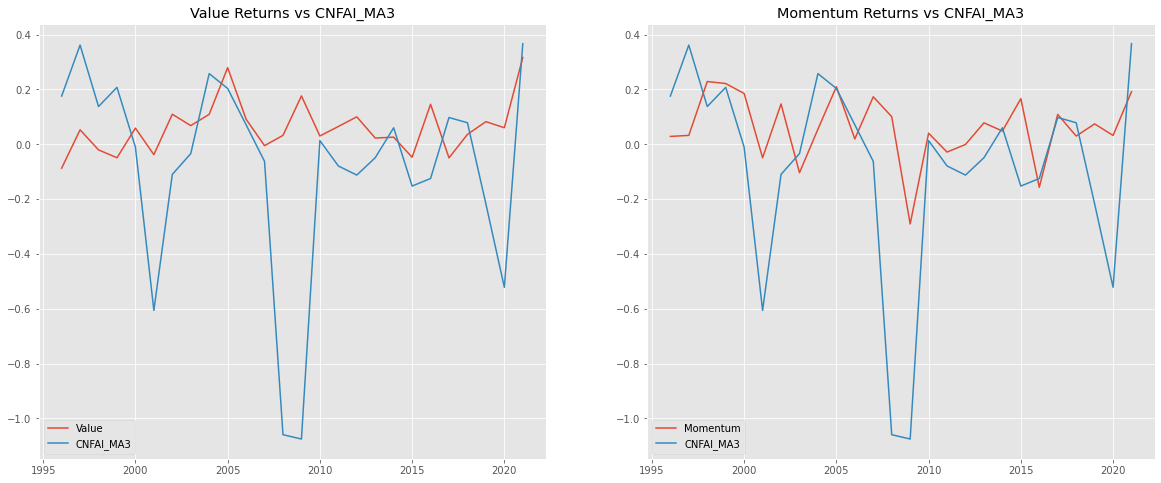

In [176]:
plot_ts('Value', 'Momentum', 'CNFAI_MA3', 'CNFAI_MA3', 12)

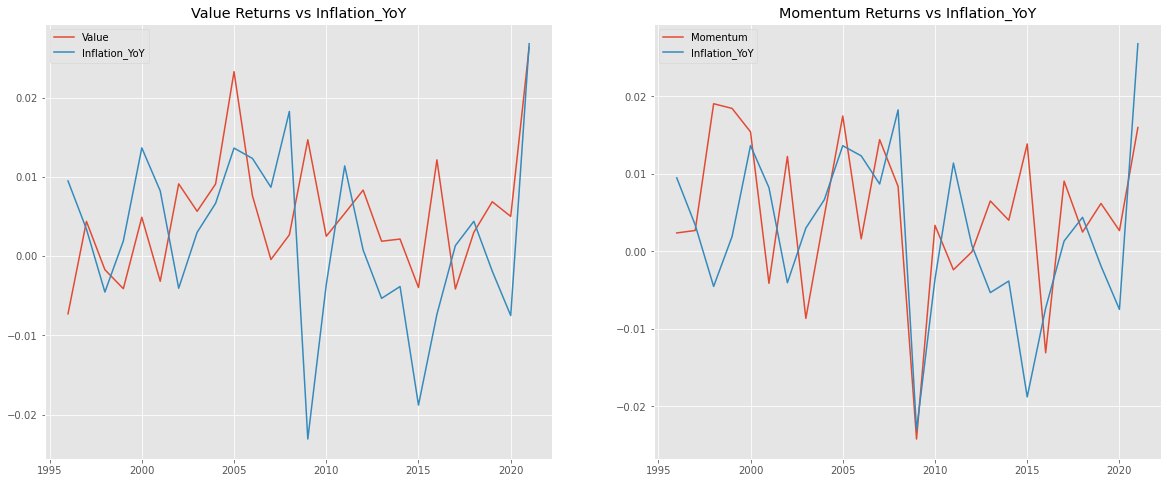

In [177]:
plot_ts('Value', 'Momentum', 'Inflation_YoY', 'Inflation_YoY', 1)

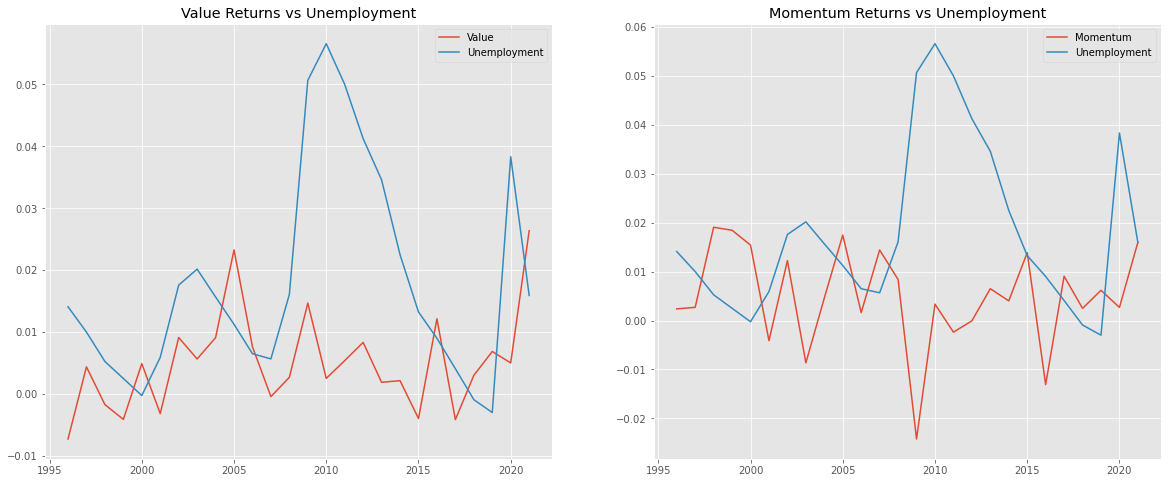

In [186]:
plot_ts('Value', 'Momentum', 'Unemployment', 'Unemployment', 1)

In [439]:
expanding_window

DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
               '2001-05-31', '2001-06-30', '2001-07-31', '2001-08-31',
               '2001-09-30', '2001-10-31',
               ...
               '2021-02-28', '2021-03-31', '2021-04-30', '2021-05-31',
               '2021-06-30', '2021-07-31', '2021-08-31', '2021-09-30',
               '2021-10-31', '2021-11-30'],
              dtype='datetime64[ns]', length=251, freq='M')

In [438]:
# r^2 of univariate regression - expanding window
timevar_list = ['CNFAI_MA3', 'Inflation_MoM']
factor_list = ['Value', 'Momentum']
expanding_window = pd.date_range(test_start_date0, test_end_date0, freq = 'M')

r2_table = pd.DataFrame(index = expanding_window)

for last_date in expanding_window: 
    for timevar in timevar_list: 
        for factor in factor_list: 
            r2, beta0, beta1 = run_ols(timevar, factor , train_start_date, last_date, 2)
            r2_table.loc[last_date, factor + '-' + timevar] = r2
    
r2_table.plot(figsize = (12,8))

ValueError: Found input variables with inconsistent numbers of samples: [310, 309]

Whats with the spike in 2009 and the drop in 2020... I wonder if its the same for the AQR/Fama-French factors... Also, does rolling-window perform better? 

<a id = 'results'> </a>
<h3> Results  

In [ ]:
# mean absolute error 
def calc_mae(forecast_df): 
    T = len(forecast_df)
    error = np.sum(np.abs(forecast_df['Forecasted Returns'] - forecast_df['Actual Returns']))
    mae = error/T
    return mae

# mean absolute percentage error
def calc_mape(forecast_df): 
    T = len(forecast_df)
    percentage_error = np.sum(np.abs((forecast_df['Forecasted Returns'] - forecast_df['Actual Returns'])/forecast_df['Actual Returns']))
    mape = (percentage_error/T)*100
    return mape

# mean absolute scaled error
def calc_mase(forecast_df): 
    T = len(forecast_df)
    num = (np.abs(forecast_df['Forecasted Returns'] - forecast_df['Actual Returns']).sum())/T
    den = (np.abs(forecast_df['Actual Returns'].shift(1) - forecast_df['Actual Returns']).sum())/(T-1)
    mase = num/den
    return mase

def calc_accuracy(method, forecast_list, date_range): 
    acc_table = pd.DataFrame(index = date_range_test, columns = [f'Gamma{x+1}' for x in range(len(forecast_list))])
    if method == 'mase': 
        for last_date in date_range_test:
            acc_table.loc[last_date,:] = [calc_mase(forecast_df.loc[test_start_date:last_date]) for forecast_df in forecast_list]
    
    return acc_table

<h4> <font color = 'darkblue'> Expanding Window </font> </h4>

In this section, we seek to test the estimation of `gamma` using an expanding window approach.

In [428]:
# compute gamma
mom_inflation_ew = calc_gamma_ew('Momentum', factor_ret_df, 'Inflation_YoY', timing_var_df, scaler = 100)
mom_GDP_ew = calc_gamma_ew('Momentum', factor_ret_df, 'CNFAI_MA3', timing_var_df, scaler = 100)
val_inflation_ew = calc_gamma_ew('Value', factor_ret_df, 'Inflation_YoY', timing_var_df, scaler = 100)
val_GDP_ew = calc_gamma_ew('Value', factor_ret_df, 'CNFAI_MA3', timing_var_df, scaler = 100)

# target portfolio returns
factor_returns_test = factor_ret_df.loc[test_start_date:test_end_date].copy()

factor_returns_test['ValMom-50-50'] = 0.5 * (factor_returns_test['Value'] + factor_returns_test['Momentum']) # naive benchmark
factor_returns_test['ValMom-gamma1']  = factor_returns_test['Value'] * (1 - mom_inflation_ew['Gamma']) + factor_returns_test['Momentum'] * (mom_inflation_ew['Gamma'])
factor_returns_test['ValMom-gamma2']  = factor_returns_test['Value'] * (1 - mom_GDP_ew['Gamma']) + factor_returns_test['Momentum'] * (mom_GDP_ew['Gamma'])
factor_returns_test['ValMom-gamma3']  = factor_returns_test['Value'] * (val_inflation_ew['Gamma']) + factor_returns_test['Momentum'] * (1 - val_inflation_ew['Gamma'])
factor_returns_test['ValMom-gamma4']  = factor_returns_test['Value'] * (val_GDP_ew['Gamma']) + factor_returns_test['Momentum'] * (1 - val_GDP_ew['Gamma'])
factor_returns_test.drop(['Value', 'Momentum'], axis = 1, inplace = True)

# target portfolio weights
factor_weights_test = {}
factor_weights_test['ValMom-50-50'] = 0.5 * (factor_weights['Value'] + factor_weights['Momentum']) 

gamma1 = (mom_inflation_ew['Gamma']).shift(-1, freq = 'infer')
factor_weights_test['ValMom-gamma1'] = factor_weights['Value'].loc[expanding_window].mul(1 - gamma1, axis = 0) + factor_weights['Momentum'].loc[expanding_window].mul(gamma1, axis = 0)

gamma2 = (mom_GDP_ew['Gamma']).shift(-1, freq = 'infer')
factor_weights_test['ValMom-gamma2'] = factor_weights['Value'].loc[expanding_window].mul(1 - gamma2, axis = 0) + factor_weights['Momentum'].loc[expanding_window].mul(gamma2, axis = 0)

gamma3 = (val_inflation_ew['Gamma']).shift(-1, freq = 'infer')
factor_weights_test['ValMom-gamma3'] = factor_weights['Value'].loc[expanding_window].mul(gamma3, axis = 0) + factor_weights['Momentum'].loc[expanding_window].mul(1 - gamma3, axis = 0)

gamma4 = (val_GDP_ew['Gamma']).shift(-1, freq = 'infer')
factor_weights_test['ValMom-gamma4'] = factor_weights['Value'].loc[expanding_window].mul(gamma4, axis = 0) + factor_weights['Momentum'].loc[expanding_window].mul(1- gamma4, axis = 0)


# compute performance measures
summary_table(factor_weights_test, factor_returns_test, test_start_date, test_end_date)

,ValMom-50-50,ValMom-gamma1,ValMom-gamma2,ValMom-gamma3,ValMom-gamma4
Return,0.0656496,0.0644774,0.0759863,0.0745834,0.0779417
Volatility,0.229582,0.248652,0.270362,0.236057,0.243339
Sharpe Ratio,0.285952,0.259307,0.281054,0.315955,0.320301
Mean Drawdown,-0.0529608,-0.0569864,-0.0815608,-0.0608216,-0.0719236
Max Drawdown,-0.196271,-0.199581,-0.2044,-0.190234,-0.191273
Turnover,5.92584,6.29858,6.6099,5.0758,5.23266
Leverage,1.02462,1.05728,1.08876,0.971625,0.975104


Okay so this is what's going on... Since we are timing the factors individually, and load more on a particular factor if the forecasted returns are positive, there is an inherent bias in loading towards the factor we are predicting, which is why for the gamma1 and gamma2 portfolios above underperforms, since momentum is on average the factor with lower returns (in this analysis).

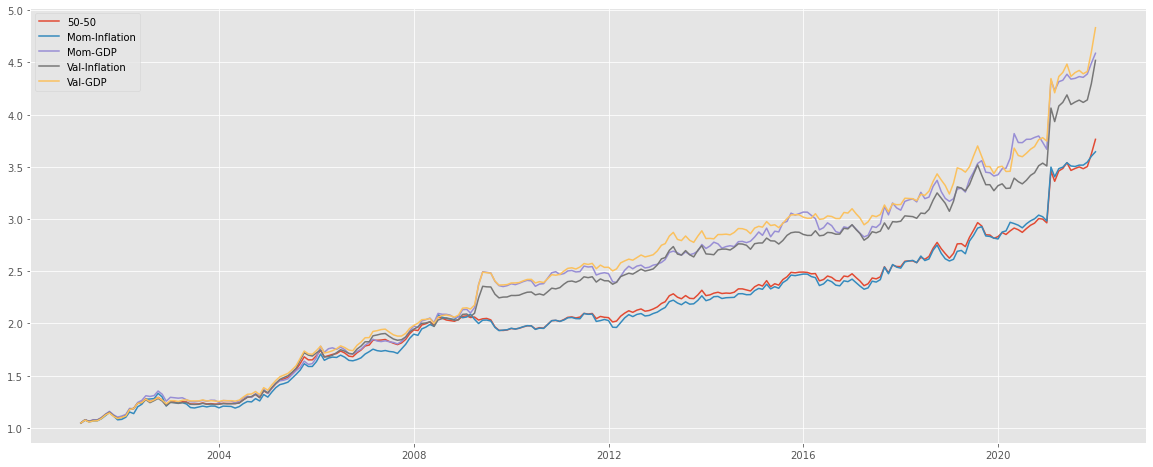

In [429]:
# cumulative returns
factor_cumret = np.cumprod(1 + factor_returns_test)

plt.figure(figsize = (20,8))
plt.plot(factor_cumret['ValMom-50-50'], label = '50-50')
plt.plot(factor_cumret['ValMom-gamma1'], label = 'Mom-Inflation')
plt.plot(factor_cumret['ValMom-gamma2'], label = 'Mom-GDP')
plt.plot(factor_cumret['ValMom-gamma3'], label = 'Val-Inflation')
plt.plot(factor_cumret['ValMom-gamma4'], label = 'Val-GDP')
plt.legend()

In [ ]:
mom_inflation_ew['Gamma'].plot()

<ipython-input-122-3ba69e3a84f6>:19: RuntimeWarning: invalid value encountered in double_scalars
  den = (np.abs(forecast_df['Actual Returns'].shift(1) - forecast_df['Actual Returns']).sum())/(T-1)


<AxesSubplot:>

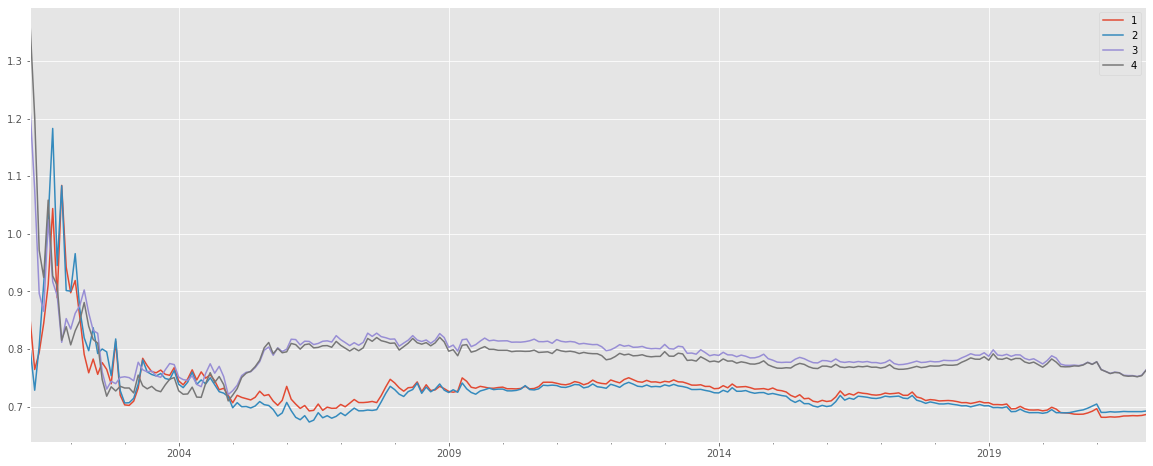

In [457]:
forecast_list = [mom_inflation_ew, mom_GDP_ew, val_inflation_ew, val_GDP_ew]
date_range_test = pd.date_range(test_start_date, test_end_date, freq = 'M')
mase_table = calc_accuracy('mase', forecast_list, date_range_test)
mase_table.iloc[2:,:].plot(figsize = (20,8))

<h4> <font color = 'darkblue'> Combining Timing Variables </font> </h4>

From the analysis above, we see that `CNFAI_MA3` is a more suitable timing variable for value, and `Inflation` is a more suitable timing variable for momentum. We want to see if we can use both timing variables to forecast the expected returns of value and momentum, and set factor loading `gamma` to maximize portfolio returns. 

The ability to derive accurate 1-period ahead forecasts of factor returns is undeniably powerful. As seen from the `ValMom-prophet` column below, if we have the prescience of knowing exactly whether value or momentum will perform better in the next period, and tilt our factor loadings accordingly, we can achieve a SR of 0.93, more than 3 times of a 50-50 static split. While such a discussion seems frivolous in the ex-ante context, it does illustrate the rewards of factor timing if nothing else. 

In [408]:
# compute gamma 
gamma_gdp_gdp = calc_gamma_binary(factor_ret_df, timing_var_df, 'CNFAI_MA3', 'CNFAI_MA3', upper_bound = 1)
gamma_gdp_inflation = calc_gamma_binary(factor_ret_df, timing_var_df, 'CNFAI_MA3', 'Inflation_YoY', upper_bound = 1)
gamma_prophet = factor_ret_df.copy()
gamma_prophet['Gamma'] = np.where(factor_ret_df['Value']>factor_ret_df['Momentum'], 1, 0)

# target portfolio returns
factor_returns_test = factor_ret_df.loc[test_start_date:test_end_date].copy()

factor_returns_test['ValMom-50-50'] = 0.5 * (factor_returns_test['Value'] + factor_returns_test['Momentum']) # naive benchmark
factor_returns_test['ValMom-gdp-inf']  = factor_returns_test['Value'] * (gamma_gdp_inflation['Gamma']) + factor_returns_test['Momentum'] * (1 - gamma_gdp_inflation['Gamma'])
factor_returns_test['ValMom-gdp-gdp']  = factor_returns_test['Value'] * (gamma_gdp_gdp['Gamma']) + factor_returns_test['Momentum'] * (1 - gamma_gdp_gdp['Gamma'])
factor_returns_test['ValMom-prophet']  = factor_returns_test['Value'] * (gamma_prophet['Gamma']) + factor_returns_test['Momentum'] * (1 - gamma_prophet['Gamma'])
factor_returns_test.drop(['Value', 'Momentum'], axis = 1, inplace = True)

# target portfolio weights
factor_weights_test = {}
factor_weights_test['ValMom-50-50'] = 0.5 * (factor_weights['Value'] + factor_weights['Momentum']) 
gamma1 = (gamma_gdp_inflation['Gamma']).shift(-1, freq = 'infer')
factor_weights_test['ValMom-gdp-inf'] = factor_weights['Value'].loc[expanding_window].mul(gamma1, axis = 0) + factor_weights['Momentum'].loc[expanding_window].mul(1 - gamma1, axis = 0)
gamma2 = (gamma_gdp_gdp['Gamma']).shift(-1, freq = 'infer')
factor_weights_test['ValMom-gdp-gdp'] = factor_weights['Value'].loc[expanding_window].mul(gamma2, axis = 0) + factor_weights['Momentum'].loc[expanding_window].mul(1 - gamma2, axis = 0)
gamma3 = (gamma_prophet['Gamma']).shift(-1, freq = 'infer')
factor_weights_test['ValMom-prophet'] = factor_weights['Value'].loc[expanding_window].mul(gamma3, axis = 0) + factor_weights['Momentum'].loc[expanding_window].mul(1 - gamma3, axis = 0)

# compute performance measures
summary_table(factor_weights_test, factor_returns_test, test_start_date, test_end_date)

,ValMom-50-50,ValMom-gdp-inf,ValMom-gdp-gdp,ValMom-prophet
Return,0.0656496,0.0833187,0.068691,0.290191
Volatility,0.229582,0.368678,0.38023,0.311313
Sharpe Ratio,0.285952,0.225993,0.180657,0.932153
Mean Drawdown,-0.0529608,-0.0974655,-0.101462,-0.0842739
Max Drawdown,-0.196271,-0.217258,-0.217461,-0.217461
Turnover,5.92584,8.91027,10.7223,13.2552
Leverage,1.02462,1.35105,1.39257,1.1224


<h4> <font color = 'darkblue'> Timing Difference in Factor Returns </font> </h4>

Now what if we forecast the difference in factor returns instead. This way, our decision making process is clear. If value is expected to outperform momentum, we would allocate more weight to value, and vice versa. 

In [460]:
# compute gamma
GDP_diff = calc_gamma_diff(factor_ret_df, 'CNFAI_MA3', timing_var_df)
inflation_diff = calc_gamma_diff(factor_ret_df, 'Inflation_YoY', timing_var_df)
unemploy_diff = calc_gamma_diff(factor_ret_df, 'Unemployment', timing_var_df)

# target portfolio returns
factor_returns_test = factor_ret_df.loc[test_start_date:test_end_date].copy()

factor_returns_test['ValMom-50-50'] = 0.5 * (factor_returns_test['Value'] + factor_returns_test['Momentum']) # static benchmark
factor_returns_test['ValMom-GDP']  = factor_returns_test['Value'] * (GDP_diff['Gamma']) + factor_returns_test['Momentum'] * (1 - GDP_diff['Gamma'])
factor_returns_test['ValMom-Inflation']  = factor_returns_test['Value'] * (inflation_diff['Gamma']) + factor_returns_test['Momentum'] * (1 - inflation_diff['Gamma'])
factor_returns_test['ValMom-Unemployment']  = factor_returns_test['Value'] * (unemploy_diff['Gamma']) + factor_returns_test['Momentum'] * (1 - unemploy_diff['Gamma'])
factor_returns_test.drop(['Value', 'Momentum'], axis = 1, inplace = True)

# target portfolio weights
factor_weights_test = {}
factor_weights_test['ValMom-50-50'] = 0.5 * (factor_weights['Value'] + factor_weights['Momentum']) 
gamma1 = (inflation_diff['Gamma']).shift(-1, freq = 'infer')
factor_weights_test['ValMom-GDP'] = factor_weights['Value'].loc[expanding_window].mul(gamma1, axis = 0) + factor_weights['Momentum'].loc[expanding_window].mul(1 - gamma1, axis = 0)
gamma2 = (GDP_diff['Gamma']).shift(-1, freq = 'infer')
factor_weights_test['ValMom-Inflation'] = factor_weights['Value'].loc[expanding_window].mul(gamma2, axis = 0) + factor_weights['Momentum'].loc[expanding_window].mul(1- gamma2, axis = 0)
gamma3 = (unemploy_diff['Gamma']).shift(-1, freq = 'infer')
factor_weights_test['ValMom-Unemployment'] = factor_weights['Value'].loc[expanding_window].mul(gamma3, axis = 0) + factor_weights['Momentum'].loc[expanding_window].mul(1- gamma3, axis = 0)

# compute performance measures
summary_table(factor_weights_test, factor_returns_test, test_start_date, test_end_date)

,ValMom-50-50,ValMom-GDP,ValMom-Inflation,ValMom-Unemployment
Return,0.0656496,0.0683834,0.0665596,0.0703144
Volatility,0.229582,0.230269,0.228845,0.230141
Sharpe Ratio,0.285952,0.296971,0.29085,0.305527
Mean Drawdown,-0.0529608,-0.0526904,-0.0519793,-0.0528676
Max Drawdown,-0.196271,-0.196619,-0.195984,-0.195979
Turnover,5.92584,5.61924,5.66201,5.601
Leverage,1.02462,1.0075,1.01051,1.0081


<AxesSubplot:>

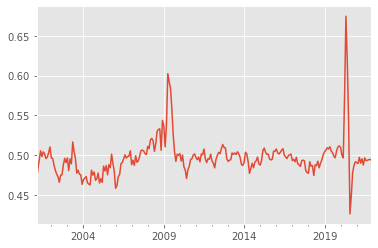

In [411]:
GDP_diff['Gamma'].plot()

In [431]:
df = pd.DataFrame(columns = ['VAL-MOM', 'GDP'])
df['VAL-MOM'] = factor_ret_df.loc[train_start_date:end_date, 'Value'] - factor_ret_df.loc[train_start_date:end_date, 'Momentum']
df['GDP'] = timing_var_df.loc[train_start_date:test_end_date, 'CNFAI_MA3']
df['Inflation'] = timing_var_df.loc[train_start_date:test_end_date, 'Inflation_YoY']
df['Unemployment'] = timing_var_df.loc[train_start_date:test_end_date, 'Unemployment']
df.corr()

,VAL-MOM,GDP,Inflation,Unemployment
VAL-MOM,1.000000,-0.128648,-0.038235,0.115650
GDP,-0.128648,1.000000,0.188534,-0.122250
Inflation,-0.038235,0.188534,1.000000,-0.294021
Unemployment,0.115650,-0.122250,-0.294021,1.000000


<ipython-input-122-3ba69e3a84f6>:19: RuntimeWarning: invalid value encountered in double_scalars
  den = (np.abs(forecast_df['Actual Returns'].shift(1) - forecast_df['Actual Returns']).sum())/(T-1)


<AxesSubplot:>

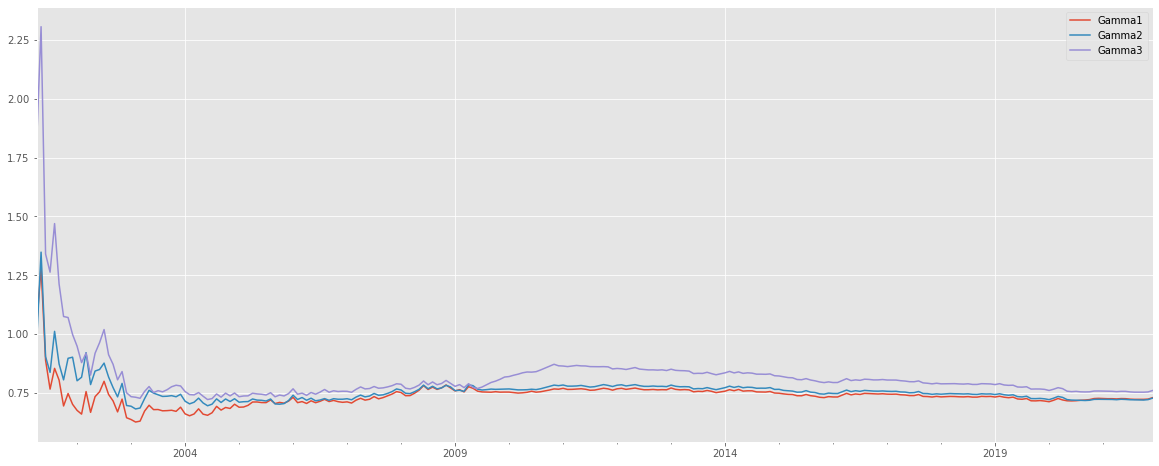

In [480]:
forecast_list_ = [GDP_diff, inflation_diff, unemploy_diff]
date_range_test = pd.date_range(test_start_date, test_end_date, freq = 'M')
mase_table = calc_accuracy('mase', forecast_list_, date_range_test)
mase_table.iloc[2:,:].plot(figsize = (20,8))

In [483]:
mase_table

,Gamma1,Gamma2,Gamma3
2001-02-28,NaN,NaN,NaN
2001-03-31,0.775011,0.578423,1.26405
2001-04-30,1.03406,0.962777,1.8063
2001-05-31,1.28162,1.3482,2.30594
2001-06-30,0.888807,0.904027,1.34036
...,...,...,...
2021-08-31,0.722902,0.720926,0.753385
2021-09-30,0.722979,0.72041,0.753465
2021-10-31,0.722857,0.719929,0.753289
2021-11-30,0.723954,0.72169,0.754356


<h2> 4. Appendix

<h3> A. Timing Variables on AQR Factors </h3> 

We tested our timing variables on the value and momentum factor returns given in [Ilmanen (2019)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3400998) to see if the sensitivies vary depending on factor construction. 

In [433]:
factor_returns1 = pd.read_excel(base_dir + "\\" + filename_3,sheet_name = "Factor Returns", index_col = 0, usecols = ['Date', 'Value', "Momentum"]).fillna(0)
factor_returns1

,Value,Momentum
Date,,
1990-01-31,0.016489,-0.024198
1990-02-28,-0.008892,-0.007082
1990-03-31,-0.032442,0.018546
1990-04-30,-0.035854,0.021893
1990-05-31,-0.043487,0.023202
...,...,...
2022-04-30,0.042944,0.052640
2022-05-31,0.065629,0.019953
2022-06-30,-0.019227,0.006325


In [ ]:
plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,8))

ax1.plot(factor_returns.loc[start_date:end_date, 'Value'] * 12, label = 'Value')
ax1.plot(timing_variables.loc[start_date:end_date, 'CNFAI_MA3'], label = 'CNFAI_MA3')
ax1.set_title('Value Returns vs Economic Activity')
ax1.legend()

ax2.plot(factor_returns.loc[start_date:end_date, 'Momentum'] * 12, label = 'Momentum')
# ax21 = ax2.twinx()
ax2.plot(timing_variables.loc[start_date:end_date, 'CNFAI_MA3'],  label = 'Inflation')
ax2.set_title('Momentum Returns vs Economic Activity')
ax2.legend()

plt.show

In [ ]:
# compute gamma
mom_inflation = calc_gamma_ew('Momentum', 'Inflation')
mom_GDP = calc_gamma_ew('Momentum', 'CNFAI_MA3')
val_inflation = calc_gamma_ew('Value', 'Inflation')
val_GDP = calc_gamma_ew('Value', 'CNFAI_MA3')

In [ ]:
# populate target portfolio returns
factor_returns_test = factor_returns1.loc[test_start_date:test_end_date].copy()

# target portfolio returns
factor_returns_test = factor_ret_df.loc[test_start_date:test_end_date].copy()

factor_returns_test['ValMom-50-50'] = 0.5 * (factor_returns_test['Value'] + factor_returns_test['Momentum']) # naive benchmark
factor_returns_test['ValMom-gamma1']  = factor_returns_test['Value'] * (1 - mom_inflation_ew['Gamma']) + factor_returns_test['Momentum'] * (mom_inflation_ew['Gamma'])
factor_returns_test['ValMom-gamma2']  = factor_returns_test['Value'] * (1 - mom_GDP_ew['Gamma']) + factor_returns_test['Momentum'] * (mom_GDP_ew['Gamma'])
factor_returns_test['ValMom-gamma3']  = factor_returns_test['Value'] * (val_inflation_ew['Gamma']) + factor_returns_test['Momentum'] * (1 - val_inflation_ew['Gamma'])
factor_returns_test['ValMom-gamma4']  = factor_returns_test['Value'] * (val_GDP_ew['Gamma']) + factor_returns_test['Momentum'] * (1 - val_GDP_ew['Gamma'])
factor_returns_test.drop(['Value', 'Momentum'], axis = 1, inplace = True)

# target portfolio weights
factor_weights_test = {}
factor_weights_test['ValMom-50-50'] = 0.5 * (factor_weights['Value'] + factor_weights['Momentum']) 

gamma1 = (mom_inflation_ew['Gamma']).shift(-1, freq = 'infer')
factor_weights_test['ValMom-gamma1'] = factor_weights['Value'].loc[expanding_window].mul(1 - gamma1, axis = 0) + factor_weights['Momentum'].loc[expanding_window].mul(gamma1, axis = 0)

gamma2 = (mom_GDP_ew['Gamma']).shift(-1, freq = 'infer')
factor_weights_test['ValMom-gamma2'] = factor_weights['Value'].loc[expanding_window].mul(1 - gamma2, axis = 0) + factor_weights['Momentum'].loc[expanding_window].mul(gamma2, axis = 0)

gamma3 = (val_inflation_ew['Gamma']).shift(-1, freq = 'infer')
factor_weights_test['ValMom-gamma3'] = factor_weights['Value'].loc[expanding_window].mul(gamma3, axis = 0) + factor_weights['Momentum'].loc[expanding_window].mul(1 - gamma3, axis = 0)

gamma4 = (val_GDP_ew['Gamma']).shift(-1, freq = 'infer')
factor_weights_test['ValMom-gamma4'] = factor_weights['Value'].loc[expanding_window].mul(gamma4, axis = 0) + factor_weights['Momentum'].loc[expanding_window].mul(1- gamma4, axis = 0)


# compute performance measures
summary_table(factor_weights_test, factor_returns_test, test_start_date, test_end_date)


In [ ]:
# cumulative returns
factor_cumret = np.cumprod(1 + factor_returns_test)

plt.figure(figsize = (20,8))
plt.plot(factor_cumret['ValMom-50-50'], label = '50-50')
plt.plot(factor_cumret['ValMom-gamma1'], label = 'Mom-Inflation')
plt.plot(factor_cumret['ValMom-gamma2'], label = 'Mom-GDP')
plt.plot(factor_cumret['ValMom-gamma3'], label = 'Val-Inflation')
plt.plot(factor_cumret['ValMom-gamma4'], label = 'Val-GDP')
plt.legend()

<h3> B. Gamma </h3>

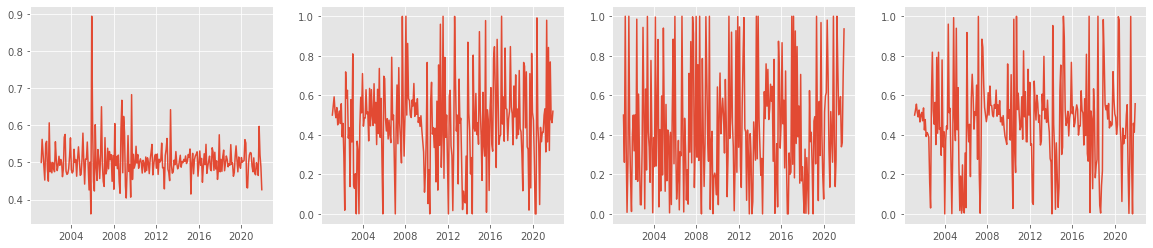

In [569]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20,4))

ax1.plot(mom_inflation['Gamma'])
ax2.plot(mom_GDP['Gamma'])
ax3.plot(val_inflation['Gamma'])
ax4.plot(val_GDP['Gamma'])

<h3> C. Time lag in predictor variable </h3>

In [ ]:
diff = 1
plt.scatter(timing_var_df.loc[start_date - pd.offsets.MonthEnd(diff):end_date - pd.offsets.MonthEnd(diff), 'CNFAI_MA3'], factor_ret_df['Value'])

<h3> D. Static Window </h3>

In this section, we seek to test the estimation of `gamma` using a static window approach. That is, we use a <u> fixed training period </u> to estimate the parameters, and use that to forecast future factor returns in the <u> testing period </u>. 

In [ ]:
# compute gamma
mom_inflation = calc_gamma('Momentum', factor_ret_df, 'Inflation', timing_var_df)
mom_GDP = calc_gamma('Momentum', factor_ret_df, 'CNFAI_MA3', timing_var_df)
val_inflation = calc_gamma('Value', factor_ret_df, 'Inflation', timing_var_df)
val_GDP = calc_gamma('Value', factor_ret_df, 'CNFAI_MA3', timing_var_df)

# target portfolio returns
factor_returns_test = factor_ret_df.loc[test_start_date:test_end_date].copy()

factor_returns_test['ValMom-50-50'] = 0.5 * (factor_returns_test['Value'] + factor_returns_test['Momentum']) # naive benchmark
factor_returns_test['ValMom-60-40'] = 0.6 * factor_returns_test['Value'] + 0.4 * factor_returns_test['Momentum'] # static 60-40 
factor_returns_test['ValMom-40-60'] = 0.4 * factor_returns_test['Value'] + 0.6 * factor_returns_test['Momentum'] # static 40-60

factor_returns_test['ValMom-gamma1']  = factor_returns_test['Value'] * (1 - mom_inflation['Gamma']) + factor_returns_test['Momentum'] * (mom_inflation['Gamma'])
factor_returns_test['ValMom-gamma2']  = factor_returns_test['Value'] * (1 - mom_GDP['Gamma']) + factor_returns_test['Momentum'] * (mom_GDP['Gamma'])
factor_returns_test['ValMom-gamma3']  = factor_returns_test['Value'] * (val_inflation['Gamma']) + factor_returns_test['Momentum'] * (1 - val_inflation['Gamma'])
factor_returns_test['ValMom-gamma4']  = factor_returns_test['Value'] * (val_GDP['Gamma']) + factor_returns_test['Momentum'] * (1 - val_GDP['Gamma'])

# target portfolio weights
factor_weights_test = {}
factor_weights_test['Value'] = factor_weights['Value']
factor_weights_test['Momentum'] = factor_weights['Momentum']
factor_weights_test['ValMom-50-50'] = 0.5 * (factor_weights['Value'] + factor_weights['Momentum']) 
factor_weights_test['ValMom-60-40'] = 0.6 * factor_weights['Value'] + 0.4 * factor_weights['Momentum']
factor_weights_test['ValMom-40-60'] = 0.4 * factor_weights['Value'] + 0.6 * factor_weights['Momentum'] 

gamma1 = (mom_inflation['Gamma']).shift(-1, freq = 'infer')
factor_weights_test['ValMom-gamma1'] = factor_weights['Value'].loc[expanding_window].mul(1 - gamma1, axis = 0) + factor_weights['Momentum'].loc[expanding_window].mul(gamma1, axis = 0)

gamma2 = (mom_GDP['Gamma']).shift(-1, freq = 'infer')
factor_weights_test['ValMom-gamma2'] = factor_weights['Value'].loc[expanding_window].mul(1 - gamma2, axis = 0) + factor_weights['Momentum'].loc[expanding_window].mul(gamma2, axis = 0)

gamma3 = (val_inflation['Gamma']).shift(-1, freq = 'infer')
factor_weights_test['ValMom-gamma3'] = factor_weights['Value'].loc[expanding_window].mul(gamma3, axis = 0) + factor_weights['Momentum'].loc[expanding_window].mul(1 - gamma3, axis = 0)

gamma4 = (val_GDP['Gamma']).shift(-1, freq = 'infer')
factor_weights_test['ValMom-gamma4'] = factor_weights['Value'].loc[expanding_window].mul(gamma4, axis = 0) + factor_weights['Momentum'].loc[expanding_window].mul(1- gamma4, axis = 0)

# compute performance measures
summary_table(factor_weights_test, factor_returns_test, test_start_date, test_end_date)

In [ ]:
# cumulative returns
factor_cumret = np.cumprod(1 + factor_returns_test)

plt.figure(figsize = (20,8))
plt.plot(factor_cumret['ValMom-50-50'], label = '50-50')
plt.plot(factor_cumret['ValMom-60-40'], label = '40-60')
plt.plot(factor_cumret['ValMom-40-60'], label = '60-40')
plt.plot(factor_cumret['ValMom-gamma1'], label = 'Mom-Inflation')
plt.plot(factor_cumret['ValMom-gamma2'], label = 'Mom-GDP')
plt.plot(factor_cumret['ValMom-gamma3'], label = 'Val-Inflation')
plt.plot(factor_cumret['ValMom-gamma4'], label = 'Val-GDP')
plt.legend()

<h3> E. Rolling Window </h3> 